In [103]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tqdm import tqdm

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from autoencoder import Autoencoder
from solver import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data

In [41]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True, num_workers=6)
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False, num_workers=6)

In [42]:
train_images = []
train_labels = []

for batch_idx, (data, target) in enumerate(train_loader):
    data = Variable(data)
    train_images.append(data)
    train_labels.append(target)

train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)
train_images = train_images.squeeze(1)

test_images = []
test_labels = []

for batch_idx, (data, target) in enumerate(test_loader):
    data = Variable(data)
    test_images.append(data)
    test_labels.append(target)

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)
test_images = test_images.squeeze(1)

### Load Model

In [43]:
size_ls = [4, 4, 4, 4, 4, 10,
        10, 10, 10, 10, 16, 16,
        16, 16, 16, 16, 16, 24,
        24, 24, 24, 24, 24, 24, 
        32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 
        32, 32, 32, 32, 32, 32, 
        32, 32, 32, 32, 32, 32, 
        32, 32]

In [44]:
def load_model(model_path, model_type, epoch):
    n_input = 28*28
    n_layers = 3
    sae_n_hidden_ls = [512, 128, 32]

    size_ls = [4, 4, 4, 4, 4, 10,
            10, 10, 10, 10, 16, 16,
            16, 16, 16, 16, 16, 24,
            24, 24, 24, 24, 24, 24, 
            32, 32, 32, 32, 32, 32,
            32, 32, 32, 32, 32, 32, 
            32, 32, 32, 32, 32, 32, 
            32, 32, 32, 32, 32, 32, 
            32, 32]
    
    dae_n_hidden_ls = [512, 128, size_ls[epoch]]
    
    if model_type == 'SAE':
        model = Autoencoder(n_input, sae_n_hidden_ls, n_layers)
    else:
        model = Autoencoder(n_input, dae_n_hidden_ls, n_layers)
    weights = torch.load(f"{model_path}/{model_type}/model_weights_epoch{epoch}.pth")
    model.load_state_dict(weights)
    return model

In [45]:
modelpath = f'/home/david/sparsify_models/good_models/01'

sae = load_model(modelpath, 'SAE', epoch=49)
dae = load_model(modelpath, 'DAE', epoch=49)

/tmp/ipykernel_33349/2098548407.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{model_path}/{model_type}/model_weights_epoch{epoch}.pth")


### Add Frequency Noise

In [46]:
def draw_circle(shape, diameter):
    assert len(shape) == 2
    TF = np.zeros(shape,dtype=np.bool)
    center = np.array(TF.shape)/2.0

    for iy in range(shape[0]):
        for ix in range(shape[1]):
            TF[iy,ix] = (iy- center[0])**2 + (ix - center[1])**2 < diameter **2
    return(TF)

def filter_circle(circle_mask, full_fft_filter):
    temp = np.zeros(full_fft_filter.shape,dtype=complex)
    temp[circle_mask] = full_fft_filter[circle_mask]
    return(temp)

def add_frequency_noise(image, noise_level=1, inner_diameter=3, outer_diameter=7):
    circle_mask         = draw_circle(shape=image.shape,diameter=inner_diameter)
    outer_circle_mask   = draw_circle(shape=image.shape, diameter=outer_diameter)
    ring_mask           = outer_circle_mask & ~circle_mask

    # FFT of the image
    fft_img = np.fft.fftshift(np.fft.fft2(image))

    # Noise in given frequency range
    noise = np.random.randn(*image.shape)
    noise = np.abs(noise_level * noise * ring_mask)

    # Combine noise and original FFT
    fft_with_noise = fft_img + noise

    img_reco = np.fft.ifft2(fft_with_noise)

    return np.abs(img_reco)

### Find Encodings without Noise

In [47]:
sae_train_encodings = []
with torch.no_grad():
    for image in train_images:
        image = torch.tensor(image.reshape(-1), dtype=torch.float32)
        encoded, decoded = sae(image)
        sae_train_encodings.append(encoded)

sae_test_encodings = []
with torch.no_grad():
    for image in test_images:
        image = torch.tensor(image.reshape(-1), dtype=torch.float32)
        encoded, decoded = sae(image)
        sae_test_encodings.append(encoded)


dae_train_encodings = []
with torch.no_grad():
    for image in train_images:
        image = torch.tensor(image.reshape(-1), dtype=torch.float32)
        encoded, decoded = dae(image)
        dae_train_encodings.append(encoded)

dae_test_encodings = []
with torch.no_grad():
    for image in test_images:
        image = torch.tensor(image.reshape(-1), dtype=torch.float32)
        encoded, decoded = dae(image)
        dae_test_encodings.append(encoded)

### Classify Encodings

In [54]:
sae_svc = LinearSVC(max_iter=1000, C=1.0)
sae_svc.fit(sae_train_encodings, train_labels)

sae_predictions = sae_svc.predict(sae_test_encodings)
accuracy = accuracy_score(test_labels, sae_predictions)
print(f'SVC trained on SAE encodings - Accuracy: {accuracy:.4f}')


dae_svc = LinearSVC(max_iter=1000, C=1.0)
dae_svc.fit(dae_train_encodings, train_labels)

dae_predictions = dae_svc.predict(dae_test_encodings)
accuracy = accuracy_score(test_labels, dae_predictions)
print(f'SVC trained on DAE encodings - Accuracy: {accuracy:.4f}')

SVC trained on SAE encodings - Accuracy: 0.8877
SVC trained on SAE encodings - Accuracy: 0.8805


In [49]:
noisy_train_images = []
for image in train_images:
    noisy_image = add_frequency_noise(image, 20, 2, 5)
    noisy_train_images.append(noisy_image)

noisy_test_images = []
for image in test_images:
    noisy_image = add_frequency_noise(image, 20, 2, 5)
    noisy_test_images.append(noisy_image)


sae_train_encodings_from_noisy_images = []
with torch.no_grad():
    for image in noisy_train_images:
        image = torch.tensor(image.reshape(-1), dtype=torch.float32)
        encoded, decoded = sae(image)
        sae_train_encodings_from_noisy_images.append(encoded)

sae_test_encodings_from_noisy_images = []
with torch.no_grad():
    for image in noisy_test_images:
        image = torch.tensor(image.reshape(-1), dtype=torch.float32)
        encoded, decoded = sae(image)
        sae_test_encodings_from_noisy_images.append(encoded)


dae_train_encodings_from_noisy_images = []
with torch.no_grad():
    for image in noisy_train_images:
        image = torch.tensor(image.reshape(-1), dtype=torch.float32)
        encoded, decoded = dae(image)
        dae_train_encodings_from_noisy_images.append(encoded)

dae_test_encodings_from_noisy_images = []
with torch.no_grad():
    for image in noisy_test_images:
        image = torch.tensor(image.reshape(-1), dtype=torch.float32)
        encoded, decoded = dae(image)
        dae_test_encodings_from_noisy_images.append(encoded)

In [55]:
sae_noisy_predictions = sae_svc.predict(sae_test_encodings_from_noisy_images)
accuracy = accuracy_score(test_labels, sae_noisy_predictions)
print(f'Classifying noisy SAE encodings - Accuracy: {accuracy:.4f}')


dae_noisy_predictions = dae_svc.predict(dae_test_encodings_from_noisy_images)
accuracy = accuracy_score(test_labels, dae_noisy_predictions)
print(f'Classifying noisy DAE encodings - Accuracy: {accuracy:.4f}')

Classifying noisy SAE encodings - Accuracy: 0.8129
Classifying noisy DAE encodings - Accuracy: 0.8347


### Classify Raw Images

In [101]:
svc = LinearSVC(max_iter=1000, C=1.0)
svc.fit(train_images.reshape(train_images.shape[0], -1), train_labels)

svc_predictions = svc.predict(test_images.reshape(-1, 28*28))
accuracy = accuracy_score(test_labels, svc_predictions)
print(f'SVC trained on original images - Accuracy: {accuracy:.4f}')

svc_noisy_predictions = svc.predict(np.array(noisy_test_images).reshape(-1, 28*28))
accuracy = accuracy_score(test_labels, svc_noisy_predictions)
print(f'SVC trained on original images - Accuracy on noisy images: {accuracy:.4f}')

SVC trained on original images - Accuracy: 0.9184
SVC trained on original images - Accuracy on noisy images: 0.4882


## Confusion Matrices

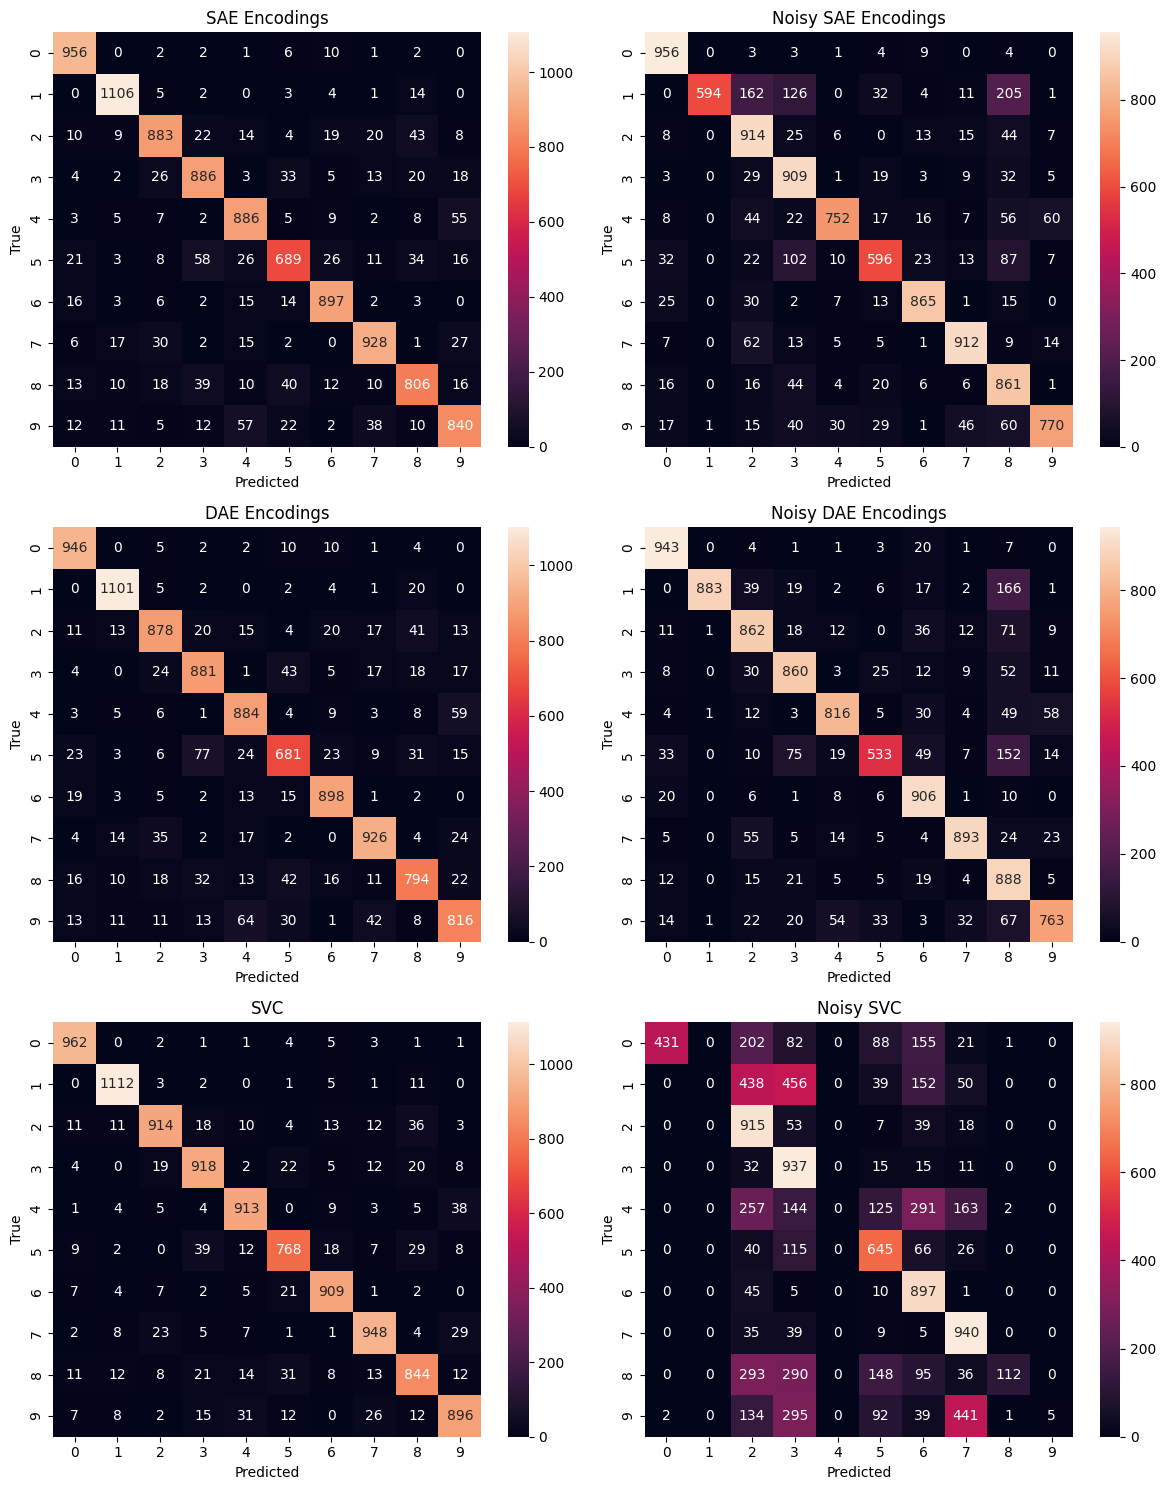

In [105]:
sae_confusion_matrix = confusion_matrix(test_labels, sae_predictions)
sae_noisy_confusion_matrix = confusion_matrix(test_labels, sae_noisy_predictions)
dae_confusion_matrix = confusion_matrix(test_labels, dae_predictions)
dae_noisy_confusion_matrix = confusion_matrix(test_labels, dae_noisy_predictions)
svc_confusion_matrix = confusion_matrix(test_labels, svc_predictions)
svc_noisy_confusion_matrix = confusion_matrix(test_labels, svc_noisy_predictions)

fig, axes = plt.subplots(3, 2, figsize=(12, 15))

sns.heatmap(sae_confusion_matrix, annot=True, fmt='d', ax=axes[0, 0])
axes[0, 0].set_title('SAE Encodings')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('True')

sns.heatmap(sae_noisy_confusion_matrix, annot=True, fmt='d', ax=axes[0, 1])
axes[0, 1].set_title('Noisy SAE Encodings')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('True')

sns.heatmap(dae_confusion_matrix, annot=True, fmt='d', ax=axes[1, 0])
axes[1, 0].set_title('DAE Encodings')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('True')

sns.heatmap(dae_noisy_confusion_matrix, annot=True, fmt='d', ax=axes[1, 1])
axes[1, 1].set_title('Noisy DAE Encodings')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('True')

sns.heatmap(svc_confusion_matrix, annot=True, fmt='d', ax=axes[2, 0])
axes[2, 0].set_title('SVC')
axes[2, 0].set_xlabel('Predicted')
axes[2, 0].set_ylabel('True')

sns.heatmap(svc_noisy_confusion_matrix, annot=True, fmt='d', ax=axes[2, 1])
axes[2, 1].set_title('Noisy SVC')
axes[2, 1].set_xlabel('Predicted')
axes[2, 1].set_ylabel('True')

# Adjust layout
plt.tight_layout()
plt.show()

## Barchart

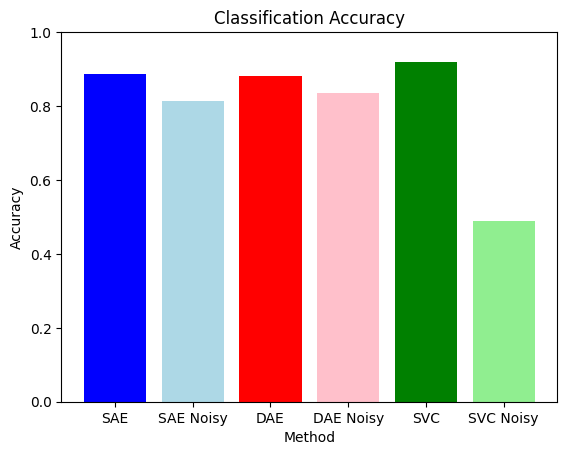

In [ ]:
names = ['SAE', 'SAE Noisy', 'DAE', 'DAE Noisy', 'SVC', 'SVC Noisy']
values = [0.8877, 0.8129, 0.8805, 0.8347, 0.9184, 0.4882]
colors = ['blue', 'lightblue', 'red', 'pink', 'green', 'lightgreen']

plt.bar(names, values, color=colors)
plt.title('Classification Accuracy')
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()